In [ ]:
# MAIN TODO:
#     - put validation set as early stopping DONE 
#     - show loss functions decrease through epochs (train, test and val) DONE 
#     - show correct and incorrect predictions DONE  
#     - can modify the layers DONE 
#     - put optuna to find best params DONE 
#     
# TOMORROW:
    # - taxas de acuracia por classe plotar DOING 
    # - talvez buscar tbm em relacao a regularizacao e dropout 
    # - descrever a parte passo a passo depois optuna 
    # - colocar no colab 
    

# aninha melhor:
# {'accuracy': 0.5393, 'balanced_accuracy': np.float64(0.5393), 'precision': 0.5331819635272109, 'recall': 0.5393, 'f1_score': 0.5336478703066184}

# Imports

In [23]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import optuna 
from optuna.trial import Trial

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn import metrics

# Helper functions and MLP class

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, activation_function):
        super(MLP, self).__init__()
        self.activation_function = activation_function

        layers_dims = [input_size] + hidden_layers + [num_classes]
        self.layers = nn.ModuleList()

        for i in range(len(layers_dims) - 1):  
            self.layers.append(nn.Linear(layers_dims[i], layers_dims[i+1]))



    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation_function(layer(x))

        x = self.layers[-1](x)
        
        return x 

In [5]:
def get_scores(targets, predictions):
    return {
        "accuracy"         : metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted"),
        "precision"        : metrics.precision_score(targets, predictions, average="weighted"),
        "recall"           : metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted")
    }

def evaluate_model(model, data_loader, loss_function):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(data_loader)

def show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val):
    plt.plot(arr_losses_train, label = "train loss")
    plt.plot(arr_losses_val, label = "val loss")
    plt.plot(arr_losses_test, label = "test loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    return None

def show_predictions(model, dataloader, num_samples):
    model.eval()
    correct_samples = []
    wrong_samples = []

    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    with torch.no_grad():
        for images, labels in dataloader:
            original_images = images

            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()

            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(labels)):
                pred = predicted[i].cpu().item()
                true = labels[i].cpu().item()
                img = original_images[i]

                if pred == true and len(correct_samples) < num_samples:
                    correct_samples.append((img, pred, true))
                elif pred != true and len(wrong_samples) < num_samples:
                    wrong_samples.append((img, pred, true))

                if len(correct_samples) >= num_samples and len(wrong_samples) >= num_samples:
                    break

    plt.figure(figsize=(24, 20))
    
    plt.subplot(1, 2, 1)
    # acertos
    for idx, (img, pred, true) in enumerate(correct_samples):
        plt.subplot(2, num_samples, idx + 1)
        img = img.permute(1, 2, 0)  
        img = img * 0.5 + 0.5 
        plt.imshow(img)
        plt.title(f'Correto!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')

    # erros
    for idx, (img, pred, true) in enumerate(wrong_samples):
        plt.subplot(2, num_samples, idx + num_samples + 1)
        img = img.permute(1, 2, 0)
        img = img * 0.5 + 0.5
        plt.imshow(img)
        plt.title(f'Erro!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')
    
    plt.tight_layout(h_pad=2)
    plt.show()

    return None

def objective(trial):
    global train_dataset_global, validation_dataset_global

    activation_name = trial.suggest_categorical('activation', ['ReLU', 'Sigmoid', 'Tanh'])
    activation_functions = {
        'ReLU': nn.ReLU(),
        'Sigmoid': nn.Sigmoid(),
        'Tanh': nn.Tanh()
    }
    activation_function = activation_functions[activation_name]
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 256)

    n_layers = trial.suggest_int('n_layers', 2, 5)
    hidden_layers = []
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_l{i}', 32, 256)
        hidden_layers.append(n_units)

    input_size = 32*32*3
    num_classes = 10
    loss_function = nn.CrossEntropyLoss()
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset_global, 
        batch_size=batch_size, 
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=validation_dataset_global, 
        batch_size=batch_size, 
        shuffle=False
    )

    model = MLP(
        input_size=input_size,
        hidden_layers=hidden_layers,
        num_classes=num_classes,
        activation_function=activation_function  
    ).cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    
    for _ in range(20):
        model.train()
        for images, labels in train_loader:
            images = images.view(-1, input_size).cuda()
            labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
        
        val_loss = evaluate_model(model, val_loader, loss_function)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
    
    return best_val_loss


# Setup

In [6]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                    ])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [7]:
# just to run fast
subset_sample      = 1000

train_dataset      = torch.utils.data.Subset(train_dataset, range(subset_sample))
validation_dataset = torch.utils.data.Subset(validation_dataset, range(subset_sample))
test_dataset       = torch.utils.data.Subset(test_dataset, range(subset_sample))


In [8]:
train_dataset_global = train_dataset
validation_dataset_global = validation_dataset

# Def hyperparameters and Loaders

In [9]:
loss_function       = nn.CrossEntropyLoss()

# Main training Loop

## Optuna optimization

In [11]:
n_trials=1
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

[I 2025-06-01 08:13:02,780] A new study created in memory with name: no-name-45dde9fe-3f8a-4e05-b6e3-58349f6012e5
[I 2025-06-01 08:13:04,072] Trial 0 finished with value: 1.9051973687277899 and parameters: {'activation': 'ReLU', 'learning_rate': 0.0026675316999086596, 'batch_size': 112, 'n_layers': 4, 'n_units_l0': 49, 'n_units_l1': 181, 'n_units_l2': 102, 'n_units_l3': 133}. Best is trial 0 with value: 1.9051973687277899.


## Best founded model

In [12]:
study.best_params

{'activation': 'ReLU',
 'learning_rate': 0.0026675316999086596,
 'batch_size': 112,
 'n_layers': 4,
 'n_units_l0': 49,
 'n_units_l1': 181,
 'n_units_l2': 102,
 'n_units_l3': 133}

In [13]:
hidden_layers = [study.best_params[f'n_units_l{i}'] for i in range(study.best_params['n_layers'])]

activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh()
}

best_activation = activation_functions[study.best_params['activation']]

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)


In [14]:
mlp = MLP(
    input_size=32*32*3,
    hidden_layers=hidden_layers,
    num_classes=10,
    activation_function=best_activation
)
# mlp.cpu()
mlp.cuda()

optimizer = torch.optim.Adam(mlp.parameters(), lr=study.best_params['learning_rate'])

best_val_loss = float('inf')
patience = 3
patience_counter = 0

arr_losses_train = []
arr_losses_test  = []
arr_losses_val   = []

# main loop
num_epochs       = 10000
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 32*32*3).cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        # forward pass
        outputs = mlp.forward(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // study.best_params['batch_size']}, Loss: {loss}')

    train_loss = epoch_loss/len(train_loader)
    val_loss   = evaluate_model(mlp, val_loader, loss_function)
    test_loss  = evaluate_model(mlp, test_loader, loss_function)

    arr_losses_train.append(train_loss)
    arr_losses_val.append(val_loss)
    arr_losses_test.append(test_loss)

    tqdm.write(f'Epoch {epoch+1}:')
    tqdm.write(f'Train Loss: {train_loss:.4f}')
    tqdm.write(f'Val Loss: {val_loss:.4f}')
    tqdm.write(f'Test Loss: {test_loss:.4f}')


    # early stopping 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("early stopping based on loss reduction when we compare to val dataset")
            break



  0%|          | 2/10000 [00:00<33:59,  4.90it/s]

Epoch 1:
Train Loss: 2.2273
Val Loss: 2.1058
Test Loss: 2.0848
Epoch 2:
Train Loss: 2.0207
Val Loss: 2.0209
Test Loss: 1.9866


  0%|          | 4/10000 [00:00<32:48,  5.08it/s]

Epoch 3:
Train Loss: 1.8220
Val Loss: 1.9766
Test Loss: 1.9471
Epoch 4:
Train Loss: 1.6643
Val Loss: 1.9389
Test Loss: 1.9185


  0%|          | 6/10000 [00:01<32:33,  5.12it/s]

Epoch 5:
Train Loss: 1.4890
Val Loss: 2.0271
Test Loss: 2.0248
Epoch 6:
Train Loss: 1.3465
Val Loss: 2.0613
Test Loss: 2.0359


  0%|          | 6/10000 [00:01<38:21,  4.34it/s]

Epoch 7:
Train Loss: 1.1773
Val Loss: 2.1610
Test Loss: 2.1160
early stopping based on loss reduction when we compare to val dataset


# Evaluate best model

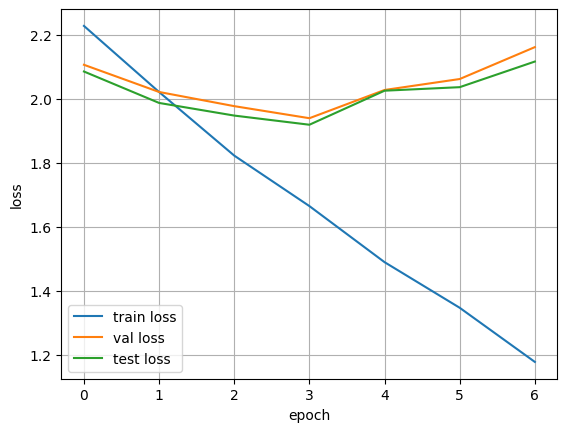

In [15]:
show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val)

/tmp/ipykernel_7142/3744762077.py:86: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(h_pad=2)


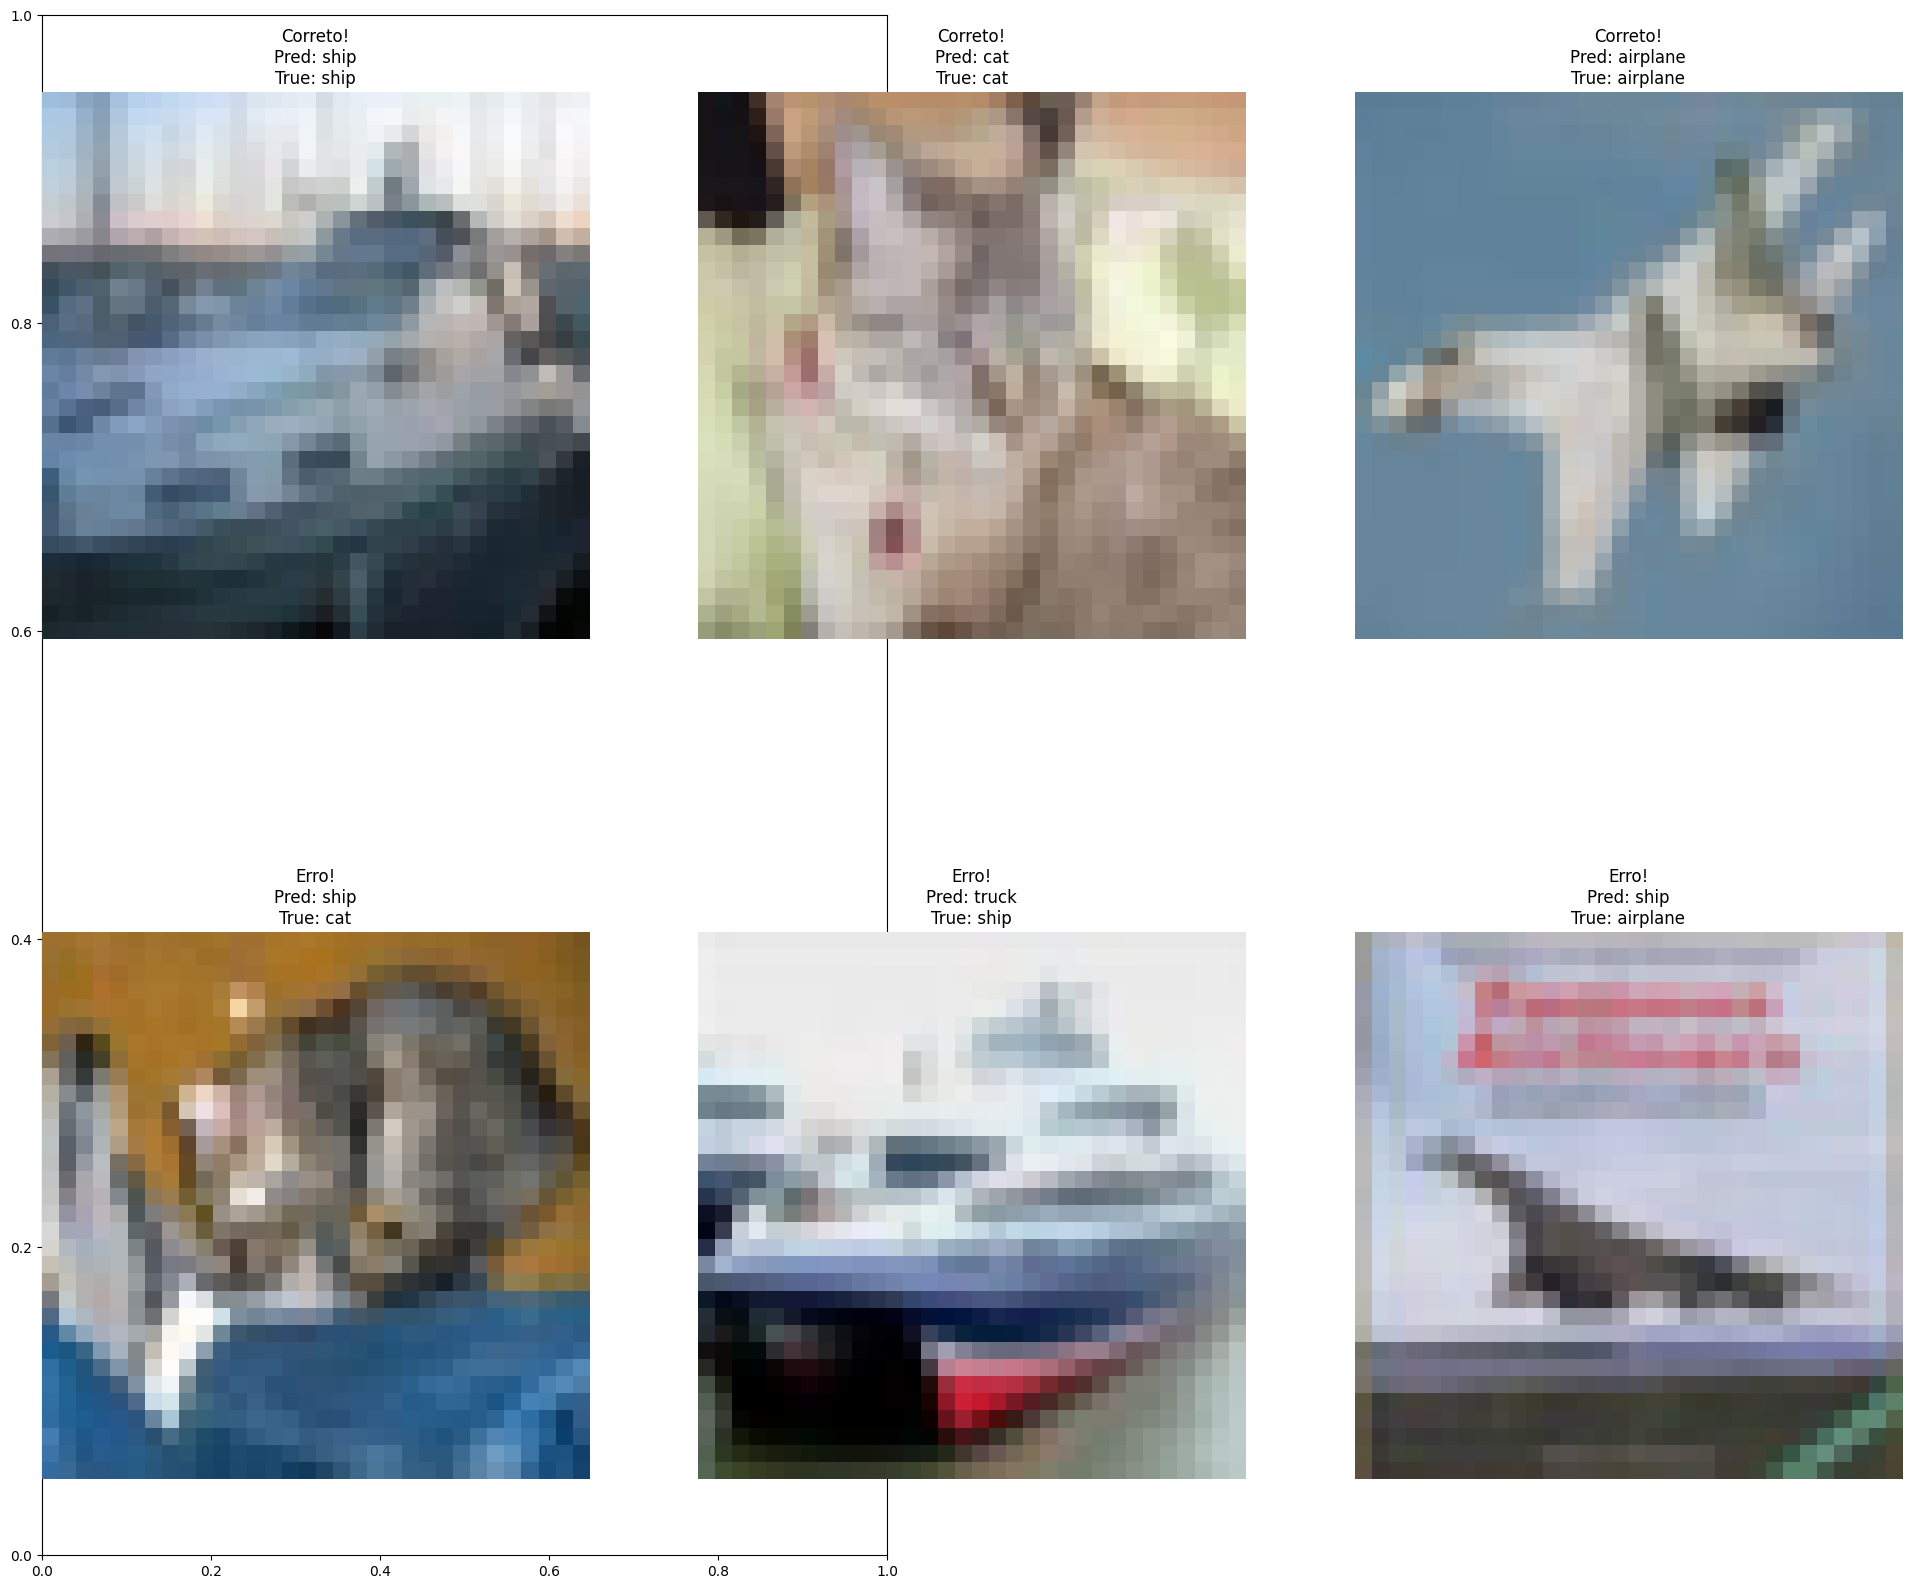

In [16]:
show_predictions(mlp, test_loader, num_samples=3)

In [17]:
mlp.eval()
predictions = []
labels = []

for images, label in test_loader:
  images = images.view(-1,32*32*3).cuda()
  label = label.cuda()

  output = mlp(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print(f"Scores of your model\n {scores}\n\n")

Scores of your model
 {'accuracy': 0.325, 'balanced_accuracy': np.float64(0.32145239790549496), 'f1_score': 0.3158587626051179, 'precision': 0.3369562413829509, 'recall': 0.325}




In [30]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

labels = np.array(labels)
predictions = np.array(predictions)

stats = {}

print(f"\n shape dataset teste -> {len(test_dataset)}")
print("\n(repr x acc top1) por classe(conjunto teste):")

for i in range(10):
    mask = labels == i
    class_acc = np.mean(predictions[mask] == labels[mask]) * 100
    num_samples = np.sum(mask)
    class_repr = (num_samples / len(labels)) * 100

    stats[classes[i]] = {
        'acuracia': f"{class_acc:.2f}%",
        'num_amostras': num_samples,
        'representatividade': f"{class_repr:.2f}%"
    }

for classe, metricas in stats.items():
    print(f"\n{classe}:")
    print(f"  Acurácia: {metricas['acuracia']}")
    print(f"  Número de amostras: {metricas['num_amostras']}")
    print(f"  Representatividade: {metricas['representatividade']}")


 shape dataset teste -> 1000

(repr x acc top1) por classe(conjunto teste):

airplane:
  Acurácia: 43.69%
  Número de amostras: 103
  Representatividade: 10.30%

automobile:
  Acurácia: 21.35%
  Número de amostras: 89
  Representatividade: 8.90%

bird:
  Acurácia: 10.00%
  Número de amostras: 100
  Representatividade: 10.00%

cat:
  Acurácia: 24.27%
  Número de amostras: 103
  Representatividade: 10.30%

deer:
  Acurácia: 32.22%
  Número de amostras: 90
  Representatividade: 9.00%

dog:
  Acurácia: 27.91%
  Número de amostras: 86
  Representatividade: 8.60%

frog:
  Acurácia: 19.64%
  Número de amostras: 112
  Representatividade: 11.20%

horse:
  Acurácia: 41.18%
  Número de amostras: 102
  Representatividade: 10.20%

ship:
  Acurácia: 43.40%
  Número de amostras: 106
  Representatividade: 10.60%

truck:
  Acurácia: 57.80%
  Número de amostras: 109
  Representatividade: 10.90%
